In [1]:
%env CUDA_VISIBLE_DEVICES=MIG-cbafb023-40ef-594e-9092-fb0e3c44baa2

env: CUDA_VISIBLE_DEVICES=MIG-cbafb023-40ef-594e-9092-fb0e3c44baa2


In [2]:
import io
import torch
import torch.nn as nn
import PIL.Image
import einops
import matplotlib.pyplot as plt
import numpy as np
import datasets
import math
import random
from timm.optim import Mars
from types import SimpleNamespace
from IPython.display import HTML
from types import SimpleNamespace
from fastprogress import progress_bar, master_bar
from torchvision.transforms.v2 import CenterCrop, RandomCrop
from torchvision.transforms.v2.functional import pil_to_tensor, to_pil_image
from decord import VideoReader
from autocodec.codec import AutoCodecND, latent_to_pil, pil_to_latent

In [3]:
device = "cuda"
dataset = datasets.load_dataset("danjacobellis/vimeo6k").cast_column('video',datasets.Video()).with_format("torch")

Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/30 [00:00<?, ?it/s]

In [4]:
config = SimpleNamespace()
config.F = 16
config.latent_dim = 192
config.input_channels = 3
config.encoder_depth = 4
config.encoder_kernel_size = 1
config.decoder_depth = 1
config.lightweight_encode = True
config.lightweight_decode = False
config.freeze_encoder_after = 0.7
config.λ = 3e-2
config.lr_pow = 6
config.epochs = 16
config.progressive_sizes = [16*int(s) for s in 2**(np.linspace(2,3.85,config.epochs))];
config.batch_size = 1
config.max_lr = (64/config.batch_size)*1e-3
config.min_lr = config.max_lr / 1e3
config.num_workers = 32
config.total_steps = config.epochs * (dataset['train'].num_rows // config.batch_size)
config.checkpoint = False
print(config.progressive_sizes[0], config.progressive_sizes[-1])

64 224


In [5]:
def get_epoch_size(epoch):
    idx = min(epoch, len(config.progressive_sizes)-1)
    return config.progressive_sizes[idx]
    
def collate_fn(batch,epoch):
    n_frames = get_epoch_size(epoch)
    h = get_epoch_size(epoch)
    w = get_epoch_size(epoch)
    batch_tensors = []
    for sample in batch:
        video = sample['video']
        len_video = len(video)
        start = random.randint(0, len_video - n_frames)
        indices = range(start, start + n_frames)
        frames = video.get_batch(indices)
        H, W = frames.shape[1], frames.shape[2]
        i = random.randint(0, H - h)
        j = random.randint(0, W - w)
        frames_cropped = frames[:, i:i+h, j:j+w, :]
        frames_cropped = frames_cropped.permute(3, 0, 1, 2)
        batch_tensors.append(frames_cropped)
    return torch.stack(batch_tensors, dim=0).to(torch.float)/127.5 - 1.0

In [6]:
model = AutoCodecND(
    dim=3,
    input_channels=config.input_channels,
    J = int(np.log2(config.F)),
    latent_dim=config.latent_dim,
    encoder_depth = config.encoder_depth,
    encoder_kernel_size = config.encoder_kernel_size,
    decoder_depth = config.decoder_depth,
    lightweight_encode = config.lightweight_encode,
    lightweight_decode = config.lightweight_decode,
).to(device)

if config.checkpoint:
    checkpoint = torch.load(config.checkpoint,weights_only=False)
    model.load_state_dict(checkpoint['state_dict'])

print(f"{sum(p.numel() for p in model.parameters())/1e6} M parameters")

optimizer = Mars(model.parameters(), lr=1.0, caution=True)

def rc_sched(i_step, config):
    t = i_step / config.total_steps
    return (config.max_lr - config.min_lr) * (1 - ((np.cos(np.pi*t))**(2*config.lr_pow))) + config.min_lr

schedule = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda i_step: rc_sched(i_step, config)
)

2449.385664 M parameters


In [ ]:
learning_rates = [optimizer.param_groups[0]['lr']]
mb = master_bar(range(config.epochs))
losses = []
rate_losses = []

global_step = 0
model.train()
for i_epoch in mb:
    #-----Train-----
    model.train()
    dataloader_train = torch.utils.data.DataLoader(
            dataset['train'],
            batch_size=config.batch_size,
            num_workers=config.num_workers,
            drop_last=True,
            shuffle=True,
            collate_fn=lambda batch: collate_fn(batch, i_epoch)
        )
    pb = progress_bar(dataloader_train, parent=mb)
    for i_batch, x in enumerate(pb):
        x = x.to(device)
        if i_epoch/config.epochs <= config.freeze_encoder_after :
            # Soft quantization with additive noise
            x_hat, rate = model(x)
        else:
            # Hard quantization
            with torch.no_grad():
                z = model.quantize.compand(model.encode(x))
                z_quant = z.round()
            rate = z.std().log2()              
            x_hat = model.decode(z_quant)

        # Loss and optimizer
        mse_loss = torch.nn.functional.mse_loss(x, x_hat).log10()
        losses.append(mse_loss.item())
        rate_losses.append(rate.item())
        total_loss = mse_loss + config.λ * rate
        total_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        schedule.step()
        learning_rates.append(optimizer.param_groups[0]['lr'])
        pb.comment = (f"PSNR: {-10*losses[-1]+6.02:.3g}, R: {rate:.2g}, LR: {learning_rates[-1]:.2g}")
        global_step += 1

    torch.save({
        'config': config,
        'state_dict': model.state_dict()
    }, 'checkpoint.pth')

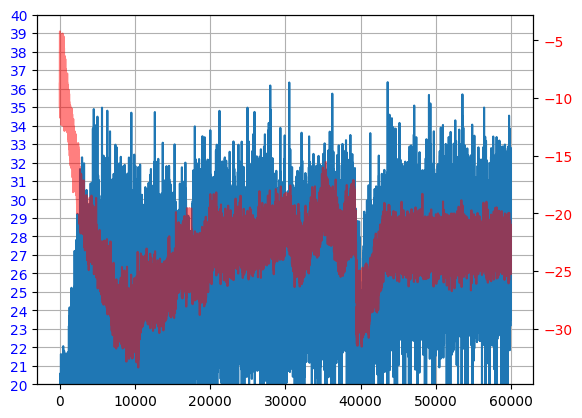

In [8]:
display(HTML(mb.main_bar.progress))
display(HTML(pb.progress))
fig, ax1 = plt.subplots()
ax1.plot(-10*np.array(losses)+6.02)
ax1.set_yticks(range(20,41))
ax1.set_ylim([20,40])
ax1.grid(True)
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(-10*np.array(rate_losses), color='red', alpha=0.5)
ax2.tick_params(axis='y', labelcolor='red')
plt.show()

In [9]:
# torch.save({
#     'config': config,
#     'state_dict': model.state_dict()
# }, '../../hf/dance/video_f16c192.pth')

In [ ]:
from IPython.display import display, clear_output
from ipywidgets import interact

model.eval()
def get_epoch_size(epoch):
    return 256
x = collate_fn(dataset['validation'].select([0]),0).to(device)

orig_dim = x.numel()

with torch.no_grad():
    z = model.encode(x)
    latent = model.quantize.compand(z).round()
latent = einops.rearrange(latent, 'b c d h w -> b (c d) h w').cpu()

webp = latent_to_pil(latent, n_bits=8, C=3)
# display(webp[0])
buff = io.BytesIO()
webp[0].save(buff, format='WEBP', lossless=True)
size_bytes = len(buff.getbuffer())

print(f"Compressed size: {size_bytes / 1e3:.2f} KB")
print(f"Compression ratio: {orig_dim / size_bytes:.2f}x")
print(f"Dimension reduction: {orig_dim / latent.numel():.2f}x")

latent_decoded = pil_to_latent(webp, N=latent.shape[1], n_bits=8, C=3)
latent_decoded = einops.rearrange(latent_decoded, 'b (c d) h w -> b c d h w', d=16).to(device)

with torch.no_grad():
    x_hat = model.decode(latent_decoded).clamp(-1, 1)

mse = torch.nn.functional.mse_loss(x, x_hat)
PSNR = -10 * mse.log10().item() + 6.02

print(f"PSNR: {PSNR:.2f} dB")

original_volume = x[0].cpu().numpy()
reconstructed_volume = x_hat[0].cpu().numpy()

def show_slices(slice_idx):
    clear_output(wait=True)
    orig_slice = to_pil_image(einops.rearrange(original_volume[:,slice_idx],'c h w -> h w c')/2+0.5)
    recon_slice = to_pil_image(einops.rearrange(reconstructed_volume[:,slice_idx],'c h w -> h w c')/2+0.5)
    display(orig_slice)
    display(recon_slice)

interact(show_slices, slice_idx=(0, original_volume.shape[1]-1, 1));

In [21]:
print(f"Compressed size: {size_bytes / 1e3:.2f} KB")
print(f"Compression ratio: {orig_dim / size_bytes:.2f}x")
print(f"Dimension reduction: {orig_dim / latent.numel():.2f}x")
print(f"PSNR: {PSNR:.2f} dB")

Compressed size: 345.66 KB
Compression ratio: 145.61x
Dimension reduction: 64.00x
PSNR: 25.49 dB


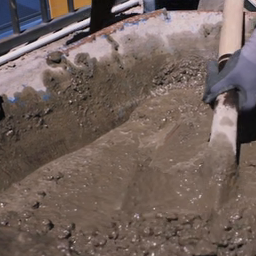

In [22]:
to_pil_image(einops.rearrange(original_volume[:,122],'c h w -> h w c')/2+0.5)

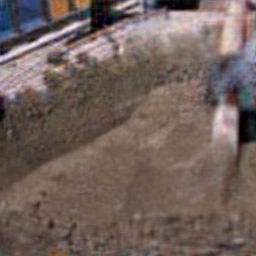

In [23]:
to_pil_image(einops.rearrange(reconstructed_volume[:,122],'c h w -> h w c')/2+0.5)

bpc: 3.894835657484253, cr: 131.4561242182707


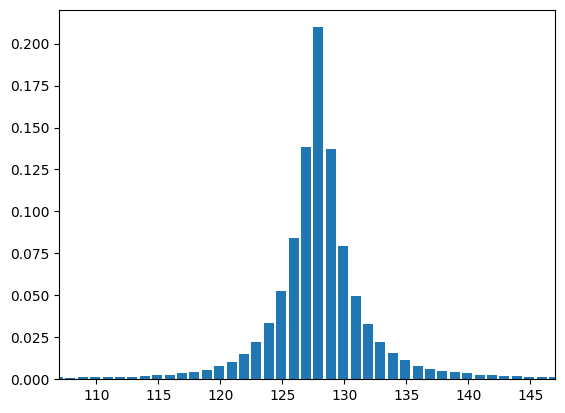

In [24]:
from torch.distributions import Categorical
x_int8 = torch.tensor(np.array(webp[0]))
h = plt.hist(x_int8.flatten(),range=(-0.5,255.5),bins=256,width=0.8,density=True)
bpc = np.log2(np.exp(1))*Categorical(torch.tensor(h[0])).entropy()
plt.xlim([127-20,127+20])
print(f"bpc: {bpc.item()}, cr: {orig_dim/latent.numel()*(8/bpc.item())}")